# 1. Download and unzip data

In [1]:
# ISIC 2016 Challenge Data (Part 3) - Skin Lesion Classification (900 Training, 379 Test Images)
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv
# !unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
# !unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

# unlabeled data - ISIC 2017 Challenge Training Data (2000 images) 
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
# !unzip "./ISIC-2017_Training_Data.zip"

# 2. Make training, validation and test image folders by training and test csv files
[ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [2]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
""" Create Directories """
# unlabeled
os.makedirs('./unlabeled', exist_ok=True)
# os.makedirs('./unlabeled/noclass', exist_ok=True)

# setup unlabeled data
num_unlabeled = 0
for filename in os.listdir("./ISIC-2017_Training_Data"):
  # only copy jpeg files
  if filename.endswith(".jpg"):
    shutil.copy("./ISIC-2017_Training_Data/"+filename, "./unlabeled/"+filename)
    # shutil.copy("./ISIC-2017_Training_Data/"+filename, "./unlabeled/noclass/"+filename)
    num_unlabeled+=1

In [3]:
""" Create Directories """
# train
os.makedirs('./train', exist_ok=True)
os.makedirs('./train/benign', exist_ok=True)
os.makedirs('./train/malignant', exist_ok=True)
# validation
os.makedirs('./val', exist_ok=True)
os.makedirs('./val/benign', exist_ok=True)
os.makedirs('./val/malignant', exist_ok=True)
# test
os.makedirs('./test', exist_ok=True)
os.makedirs('./test/benign', exist_ok=True)
os.makedirs('./test/malignant', exist_ok=True)



df = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
img_lis = []
lbl_lis = []
img_lis.append("ISIC_0000000")
lbl_lis.append("benign")
for i in range(len(df)):
    name, label = df["ISIC_0000000"][i], df["benign"][i]
    img_lis.append(name)
    lbl_lis.append(label)
N_train_val = len(img_lis)
N_train = int(N_train_val * 0.8)
print(N_train_val)
print(N_train)
shuffle_ix = np.random.permutation(np.arange(N_train_val))
ix_train = shuffle_ix[:N_train]
ix_val = shuffle_ix[N_train:]
for i in ix_train:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")
for i in ix_val:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./val/"+label+"/"+name+".jpg")

if not os.path.exists("./test"):
    os.makedirs("./test")
    os.makedirs("./test/benign")
    os.makedirs("./test/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Test_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg", "./test/benign/ISIC_0000003.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000003"][i], df["0.0"][i]
    label = "benign" if label == 0 else "malignant"
    shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./test/"+label+"/"+name+".jpg")

900
720


# 3. Prepare data and build dataloaders

In [4]:
from torch.utils.data import Dataset
from PIL import Image

class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_filenames = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image_name = self.image_filenames[index]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch

root_train, root_val, root_test = './train', './val', './test' # -- write your codes here: the root path of training/validation/test set
root_unlabeled = './unlabeled'

# Taken from sample assignment 2
def label_statistics(train_dataset):
    cls_count = np.zeros(2).astype(np.int64)

    for i, label in train_dataset:
        cls_count[label] += 1
    return cls_count

def label_weights_for_balance(train_dataset):
    cls_count = label_statistics(train_dataset)
    labels_weight_list = []
    for i, label in train_dataset:
        weight = 1 / cls_count[label]
        labels_weight_list.append(weight)
    return labels_weight_list


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),       # using stronger augmentation functions to enhance performance or solve LT problem
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

unlabeled_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),       # using stronger augmentation functions to enhance performance or solve LT problem
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def get_train_test_set(batch_size):
    """ return train, validation, test, unlabeled dataloader """
    
    train_dataset = ImageFolder(root_train, transform=train_transform)
    ### weighted sampling to tackle class imbalance
    # weights = label_weights_for_balance(train_dataset)
    # sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=650, replacement=True)
    # loader_train = torch.utils.data.DataLoader(
    #     train_dataset, sampler=sampler_train,
    #     batch_size=batch_size,
    # )
    loader_train = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
        )
    
    val_dataset = ImageFolder(root_val, transform=test_transform)
    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    test_dataset = ImageFolder(root_test, transform=test_transform)
    loader_test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
        )
    
    unlabeled_dataset = UnlabeledImageDataset(root_unlabeled, transform=unlabeled_transform)
    loader_unlabeled = torch.utils.data.DataLoader(
        dataset=unlabeled_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    return loader_train, loader_val, loader_test, loader_unlabeled

batch_size = 16
loader_train, loader_val, loader_test, loader_unlabeled = get_train_test_set(batch_size)

# 4. Build the network

## Implement ResNet50

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class Bottleneck(nn.Module):
    '''
    The single block in ResNet
    '''
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # stacking layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        '''
        Buiding ResNet layer by stacking blocks
        '''
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x

def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
    if pre_trained:
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

## Create Classification Model

In [7]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

resnet50 = get_resnet50(pre_trained=True)
model = ClassificationModel(resnet50, 1)

### 5. Train and test your model

In [8]:
import gc
# reset GPU memory if needed
def reset_gpu_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [9]:
reset_gpu_mem()

In [10]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

#### 5.1 Semi-Supervised Learning (SSL) with Pseudo-labeling

In [17]:
max_epoch = 10
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
    
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


ssl_loss_list, ssl_val_loss_list = [], [] # record the training loss
unsupervised_loss_list, supervised_loss_list = [],[] # record the unsupervised loss
ssl_auc_train_list, ssl_acc_train_list = [], [] # record the training metrics
ssl_auc_val_list, ssl_acc_val_list = [], [] # record the validation metrics

for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    ### training the model
    model.train()
    running_loss = 0.0
    running_supervised_loss, running_unsupervised_loss  = 0.0, 0.0
    train_lbl = []
    train_pred = []

    # labeled data
    for labeled_data, unlabeled_data in zip(loader_train, loader_unlabeled):
        optimizer.zero_grad()
        # labeled
        images, labels = labeled_data
        labels = labels.float()
        if use_cuda:
            images = images.cuda()
            labels = labels.float().cuda()
        outputs = model(images)[:,0]
        outputs = torch.sigmoid(outputs)
        supervised_loss = criterion(outputs, labels)
        running_supervised_loss += supervised_loss.item()

        # unlabled
        images_unlabeled = unlabeled_data
        if use_cuda:
            images_unlabeled = images_unlabeled.cuda()
        with torch.no_grad():
            pseudo_outputs = model(images_unlabeled)[:, 0]
        pseudo_outputs = torch.sigmoid(pseudo_outputs)
        pseudo_labels = (pseudo_outputs > 0.5).float()  # Simple thresholding to create pseudo-labels

        unsupervised_loss = criterion(pseudo_outputs, pseudo_labels)
        running_unsupervised_loss += unsupervised_loss.item()
        
        loss = supervised_loss + unsupervised_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_scores = list(outputs.detach().cpu().numpy())
        y_true = list(labels.detach().cpu().numpy())
        train_lbl += y_true
        train_pred += y_scores

    # record loss
    # -- write your codes here
    loss = running_loss / (len(loader_train))
    ssl_loss_list.append(loss)
    unsupervised_loss_list.append(running_unsupervised_loss)
    supervised_loss_list.append(running_supervised_loss)
    train_lbl, train_pred = np.array(train_lbl), np.array(train_pred)
    train_pred_lbl = np.around(train_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    train_auc = roc_auc_score(train_lbl, train_pred)
    train_acc = accuracy_score(train_lbl, train_pred_lbl)
    ssl_auc_train_list.append(train_auc)
    ssl_acc_train_list.append(train_acc)


    # validation
    model.eval()
    test_lbl, test_pred = [], []
    val_loss = 0.0
    for data in loader_val:
        test_images, test_labels = data
        test_labels = test_labels.float()
        if use_cuda:
            test_images = test_images.cuda()
            test_labels = test_labels.float().cuda()
        with torch.no_grad():
            test_outputs = model(test_images)[:, 0]
        test_outputs = torch.sigmoid(test_outputs)
        y_scores = list(test_outputs.detach().cpu().numpy())
        y_true = list(test_labels.detach().cpu().numpy())
        test_lbl += y_true
        test_pred += y_scores
        
        v_loss = criterion(test_outputs, test_labels)
        val_loss += v_loss.item()

    # record validation loss
    test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
    test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    test_auc = roc_auc_score(test_lbl, test_pred)
    test_acc = accuracy_score(test_lbl, test_pred_lbl)
    ssl_auc_val_list.append(test_auc)
    ssl_acc_val_list.append(test_acc)
    val_loss = val_loss / len(loader_val)
    ssl_val_loss_list.append(val_loss)
    print(f'Train Loss: {loss}, Val Loss: {val_loss}, Train AUC: {train_auc}, Val AUC: {test_auc}, Train Acc: {train_acc}, Val Acc: {test_acc}')


# evaluate on test set
model.eval()
ssl_test_lbl, ssl_test_pred = [], []
for data in loader_val:
    test_images, test_labels = data
    test_labels = test_labels.float()
    if use_cuda:
        test_images = test_images.cuda()
        test_labels = test_labels.float().cuda()
    test_outputs = model(test_images)[:, 0]
    test_outputs = torch.sigmoid(test_outputs)
    y_scores = list(test_outputs.detach().cpu().numpy())
    y_true = list(test_labels.detach().cpu().numpy())
    ssl_test_lbl += y_true
    ssl_test_pred += y_scores

# compute and print the metrics on test set
ssl_test_lbl, baseline_test_pred = np.array(ssl_test_lbl), np.array(ssl_test_pred)
ssl_test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
ssl_test_auc = roc_auc_score(ssl_test_lbl, ssl_test_pred)
ssl_test_acc = accuracy_score(ssl_test_lbl, ssl_test_pred_lbl)
print("\nSemi-Supervised Model Test Results")
print(f'Testing AUC: {ssl_test_auc}, Testing Accuracy: {ssl_test_acc}')

 -- Epoch 1/10
Train Loss: 0.5523131494982201, Val Loss: 0.4363061667148334, Train AUC: 0.8117928616294695, Val AUC: 0.8354247104247104, Train Acc: 0.8255555555555556, Val Acc: 0.8052631578947368
 -- Epoch 2/10
Train Loss: 0.5016046286674968, Val Loss: 0.43873387698355754, Train AUC: 0.8614147935533629, Val AUC: 0.8095238095238095, Train Acc: 0.8466666666666667, Val Acc: 0.8105263157894737
 -- Epoch 3/10
Train Loss: 0.5294536247588041, Val Loss: 0.4574268265084053, Train AUC: 0.8322188739852591, Val AUC: 0.7847490347490347, Train Acc: 0.8355555555555556, Val Acc: 0.8
 -- Epoch 4/10
Train Loss: 0.5324554385846121, Val Loss: 0.46065621540644014, Train AUC: 0.8166508972656654, Val AUC: 0.7833011583011583, Train Acc: 0.8355555555555556, Val Acc: 0.8210526315789474
 -- Epoch 5/10
Train Loss: 0.5092108437889501, Val Loss: 0.4309051348536741, Train AUC: 0.8537341676539107, Val AUC: 0.8305984555984556, Train Acc: 0.8511111111111112, Val Acc: 0.8157894736842105
 -- Epoch 6/10
Train Loss: 0.5237

Plots

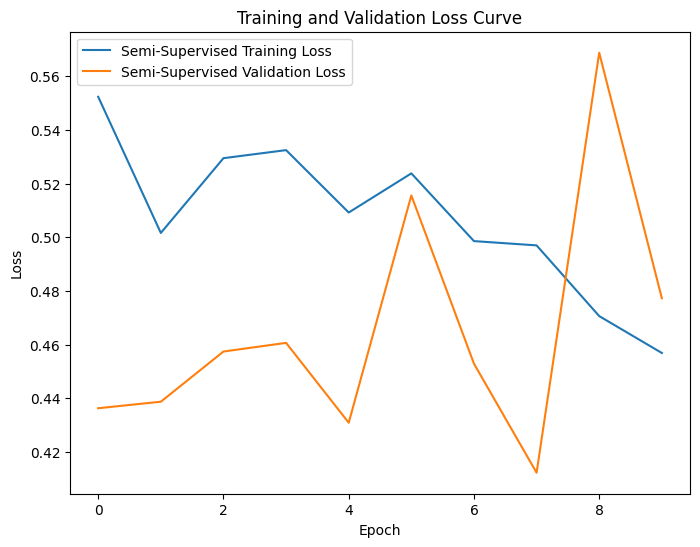

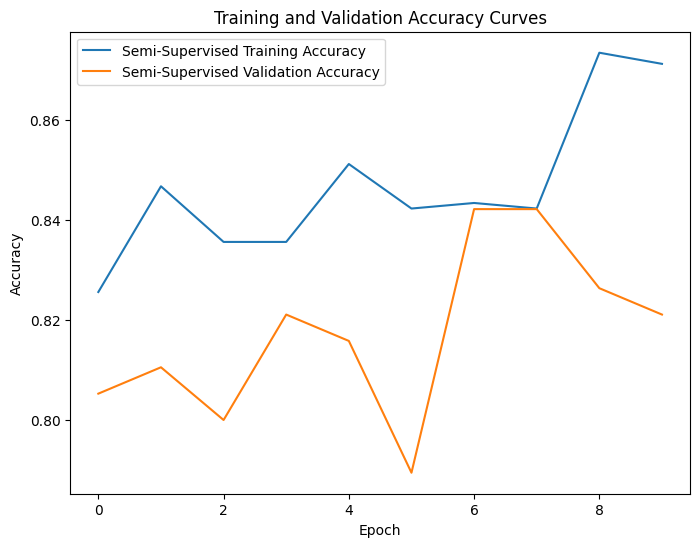

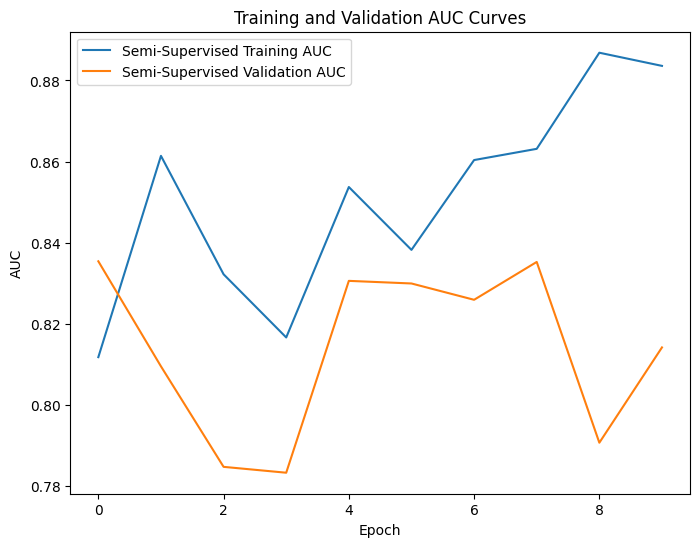

In [18]:
import matplotlib.pyplot as plt

# Plotting the training loss curve
plt.figure(figsize=(8, 6))
plt.plot(ssl_loss_list, label='Semi-Supervised Training Loss')
plt.plot(ssl_val_loss_list, label='Semi-Supervised Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

# Plotting the training and testing accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(ssl_acc_train_list, label='Semi-Supervised Training Accuracy')
plt.plot(ssl_acc_val_list, label='Semi-Supervised Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()

# Plotting the training and testing accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(ssl_auc_train_list, label='Semi-Supervised Training AUC')
plt.plot(ssl_auc_val_list, label='Semi-Supervised Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC Curves')
plt.legend()
plt.show()